## Introduction

The aim of this code is to develop a model recognizing signs from one to ten, with a simple CNN graphic training model. Our final form of data are plots with 6 lines, representing movements of five fingers and the palm from fist to the sign.

The original data is from https://github.com/MEICLabFZU/Gesture-Recognition-based-on-IMU

In [1]:
import torchvision
import sys,os
sys.path.append(os.pardir)
import glob as glob
import numpy as np
import re

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

### Convert all data into plots

Our initial data are text files with numbers only. A final graph of the sign process are made from 12 text files that two of them generates the x-value and y-value of one line.

Thus we need:

- a function to delete all empty rows at the last of text files

- a function to convert numbers in the text file to a numpy array

In [7]:
def remove_last_line(l=[""]):
    while l[-1]=="":
        l.remove(l[-1])
        
    return l

In [9]:
def txt_to_array(xn=""):
    x1=open(xn,"rb")
    lx = x1.read().splitlines()
    str_lx=[x.decode('utf-8-sig') for x in lx]
    str_lx=remove_last_line(str_lx)
    lx_=np.float_(str_lx)
    return(lx_)

Each 12 files representing one movement are saved in the same directory, and then in the directory with "sign_pack" which sign is what the data standing for. 

Then the process to convert 12 texts in one folder into a simgle graph is simple. All we need to do is to iterate each folder under one directory until we finished plotting all data for all sign.

In [18]:
path="C:\\Users\\yexue\\Gesture-Recognition-based-on-IMU\\data\\supplementarydata"
fig_path="C:\\Users\\yexue\\Gesture-Recognition-based-on-IMU\\data\\figs_supp"

### Peep look into the original and the final data

As shown below, the original data is in the form of a text file represent data on one axis of a line in a single plot. For example, following code printed the first 20 lines of data on x-axis of fore finger movement when showing eight.

In [19]:
# only show first 20 lines of the text file
x=open(os.path.join(path,'1.data\\one-1.txt'),"r")
list_x=x.read().splitlines()
print(len(list_x))
list_x[:20]

1200


['188.5836623692839',
 '188.49997627509987',
 '188.26995488234772',
 '188.00490746933494',
 '187.82819793030413',
 '187.876425085561',
 '188.31601159932808',
 '189.25016596842872',
 '190.26262523163038',
 '190.03506711893377',
 '188.2202994280498',
 '186.43506575248705',
 '184.58211721041843',
 '179.84250656893965',
 '186.18673410610037',
 '190.49862677723414',
 '196.0562241467781',
 '198.3283803931128',
 '200.28871246493242',
 '198.54261366044238']

1200
[198.28846887 198.13431381 197.88804743 197.50995118 197.03608453
 196.66207286 196.4992172  196.55308216 196.82901418 197.24323546
 197.68827239 198.12465381 198.40609804 198.25494977 197.57420124
 196.55164467 195.52567173 195.12324117 195.71763849 196.937023  ]


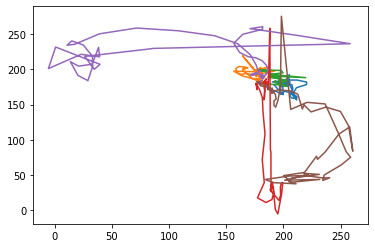

In [28]:
lx = txt_to_array(os.path.join(path,'8.data\\eight-1.txt'))
print(len(lx))
print(lx[:20])
width = len(lx)//12

for i in range(6):
    x1 = lx[i * width:(i+1) * width]
    y1 = lx[(i+1) * width:(i+2) * width]
    plt.plot(x1,y1)

In [49]:
signList=os.listdir(path)
signList=[int(x.split(".")[0]) for x in signList]
signList
sign=signList[1]
sign_path=os.path.join(path,str(sign) + ".data")
sign_path
packs=os.listdir(sign_path)
pack=packs[2]
re.findall(r'[0-9]+|[a-z]+',pack)[:-1]


['ten', '100']

In [54]:
# create a directory
if not os.path.isdir(fig_path):
    os.mkdir(fig_path)
    fig_path=os.path.join(fig_path,"train")
    os.mkdir(fig_path)
    
# the list to store all folder for different signs under the initial path
signList=os.listdir(path)
signList=[int(x.split(".")[0]) for x in signList]

for sign in signList: # look for sign 1-10
    sp=os.path.join(fig_path,str(sign))
    if not os.path.isdir(sp):
        os.mkdir(sp) # make directory for each sign to save plots
    sign_path=os.path.join(path,str(sign) + ".data")
    
    packs=os.listdir(sign_path)
    for data in packs: # for each pack of one sign, generate the plot respectively
        file_name=os.path.join(sign_path, data)
        lx = txt_to_array(file_name)
        for i in range(6):
            x1 = lx[i * width:(i+1) * width]
            y1 = lx[(i+1) * width:(i+2) * width]
            plt.plot(x1,y1)
        #plt.savefig(os.path.join(fig_path,sign,str(pack))+".jpg")
        lis=re.findall(r'[0-9]+|[a-z]+',data)[:-1]
        if len(lis)==1:
            lis.append("1")
        fig=".".join(lis)
        plt.savefig(os.path.join(fig_path,str(sign),fig)+".jpg")
        plt.clf() # clear matplotlib space
        #print(pack)
    print(str(sign)+" done!")



1 done!
10 done!
2 done!
3 done!
4 done!
5 done!
6 done!
7 done!
8 done!
9 done!


<Figure size 432x288 with 0 Axes>

The generated plots looks as follows that each color represents movement of one part of the hand. This is the an example of sign eight.

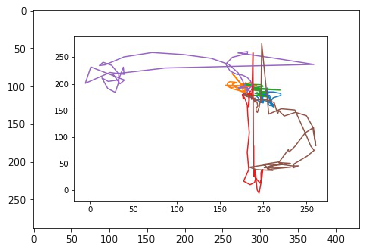

In [55]:
import cv2
packs=os.listdir(os.path.join(fig_path,"8"))
import matplotlib.image as mpimg
img=mpimg.imread(os.path.join(fig_path,"8\\eight.1.jpg"))
imgplot = plt.imshow(img)
plt.show()

### Using pytorch to analyze the plots

We have generated the plots of sign movement. In order to make and train the model, this step is to devide the data into "train" and "valid" parts. Since our data size is quite small (about 22 plots for each sign), train size:valid size is approximately 2:1, which is not a usual ratio for such training.

First we import all packages.

In [1]:
#pytorch

import glob as glob
import os
import numpy as np
import matplotlib.pyplot as plt
import shutil
from torchvision import transforms
from torchvision import models
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch import optim
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import Dataset,DataLoader
import time
%matplotlib inline

import math

To split the data into train data and valid data, we shuffle first and then take the first one third of all.

In [2]:
path = "C:\\Users\\yexue\\Gesture-Recognition-based-on-IMU\\data\\figs_supp\\"
train_path=os.path.join(path,"train")
packs=os.listdir(train_path)
if not os.path.isdir(os.path.join(path,'valid')):
    os.mkdir(os.path.join(path,'valid'))
valid_path=os.path.join(path,'valid')


In [4]:
for pack in packs:
#     print(pack)
    files=glob.glob(os.path.join(train_path,pack,"*.jpg"))
#     print(os.path.join(train_path,pack,"*.jpg"))
    num = len(files)
    valid_size = math.floor(num/3)
    shuffle = np.random.permutation(num)
#     print(shuffle)
    
    valid_path=os.path.join(path,'valid')
    if not os.path.isdir(valid_path):
        os.mkdir(valid_path)
    pack_path = os.path.join(valid_path,pack)
    if not os.path.isdir(pack_path):
        os.mkdir(os.path.join(valid_path,pack))
    
    for i in shuffle[0:valid_size]:
#         folder = files[i].split('\\')[-1].split('.')[0]

        image = files[i].split('\\')[-1]
#         print(image)
        os.rename(files[i],os.path.join(path,'valid',pack,image))
    

Model construction and training part. (Refer from an example to classify dogs and cats.)

In [5]:
simple_transform = transforms.Compose([transforms.Resize((224,224))
                                       ,transforms.ToTensor()
                                       ,transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
train = ImageFolder(train_path,simple_transform)
valid = ImageFolder(valid_path,simple_transform)

torch.Size([3, 224, 224])


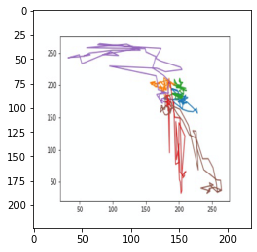

In [6]:
def imshow(inp,cmap=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp,cmap)
   
imshow(valid[50][0])
print(valid[50][0].shape)

In [7]:
train_data_loader = torch.utils.data.DataLoader(train,batch_size=64,shuffle=True)
valid_data_loader = torch.utils.data.DataLoader(valid,batch_size=64,shuffle=True)

In [8]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
#         self.conv2_drop = nn.Dropout2d()
#         self.fc1 = nn.Linear(320, 500)
        self.fc1 = nn.Linear(56180,500)
        self.fc2 = nn.Linear(500,50)
        self.fc3 = nn.Linear(50, 10)

    def forward(self, x):
#         print(x.size())  # [5,3,28,28]
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) # [3,224,224]
#         print(x.size())  # [5,10,12,12]
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
#         print(x.size())  # [5,20,4,4]
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
#         print(x.size())  # [5,40]
        #x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
#         print(x.size())  # [5,10]
        #x = F.dropout(x,training=self.training)
        x = self.fc3(x)
#         print(x.size())  # [5,10]

        return F.log_softmax(x,dim=1)

In [9]:
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
#         self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
#         self.conv2_drop = nn.Dropout2d()
#         self.fc1 = nn.Linear(320, 50)
#         self.fc2 = nn.Linear(50, 10)

#     def forward(self, x):
#         x = F.relu(F.max_pool2d(self.conv1(x), 2))
#         x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
#         x = x.view(x.size(0),-1)
#         x = F.relu(self.fc1(x))
#         x = F.dropout(x, training=self.training)
#         x = self.fc2(x)
#         return F.log_softmax(x)

In [10]:
model = Net()
optimizer = optim.SGD(model.parameters(),lr=0.01,momentum=0.5)

In [11]:
def fit(epoch,model,data_loader,phase='training',volatile=False):
    if phase == 'training':
        model.train()
    if phase == 'validation':
        model.eval()
        volatile=True
    running_loss = 0.0
    running_correct = 0
    for batch_idx , (data,target) in enumerate(data_loader):
#         if is_cuda:
#             data,target = data.cuda(),target.cuda()
        data , target = Variable(data,volatile),Variable(target)
        if phase == 'training':
            optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output,target)
        
        running_loss += F.nll_loss(output,target,size_average=False).item()
        preds = output.data.max(dim=1,keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == 'training':
            loss.backward()
            optimizer.step()
    
    loss = running_loss/len(data_loader.dataset)
    accuracy = 100. * running_correct/len(data_loader.dataset)
    
    print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)}{accuracy:{10}.{4}}')
    return loss,accuracy

In [12]:
train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]
for epoch in range(1,10):
    epoch_loss, epoch_accuracy = fit(epoch,model,train_data_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,model,valid_data_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

C:\Users\yexue\Anaconda3\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


training loss is   2.3 and training accuracy is 97/1040     9.327
validation loss is   2.3 and validation accuracy is 51/510      10.0
training loss is   2.3 and training accuracy is 125/1040     12.02
validation loss is   2.3 and validation accuracy is 51/510      10.0
training loss is   2.3 and training accuracy is 121/1040     11.63
validation loss is   2.3 and validation accuracy is 79/510     15.49
training loss is   2.3 and training accuracy is 216/1040     20.77
validation loss is   2.2 and validation accuracy is 153/510      30.0
training loss is   2.2 and training accuracy is 342/1040     32.88
validation loss is   2.1 and validation accuracy is 265/510     51.96
training loss is   2.0 and training accuracy is 494/1040      47.5
validation loss is   1.8 and validation accuracy is 272/510     53.33
training loss is   1.6 and training accuracy is 552/1040     53.08
validation loss is   1.5 and validation accuracy is 205/510      40.2
training loss is  0.98 and training accuracy 

In [15]:
for epoch in range(1,10):
    epoch_loss, epoch_accuracy = fit(epoch,model,train_data_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,model,valid_data_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

training loss is  0.36 and training accuracy is 934/1040     89.81
validation loss is  0.41 and validation accuracy is 449/510     88.04
training loss is  0.17 and training accuracy is 995/1040     95.67
validation loss is  0.22 and validation accuracy is 475/510     93.14
training loss is 0.097 and training accuracy is 1015/1040      97.6
validation loss is  0.11 and validation accuracy is 489/510     95.88
training loss is 0.069 and training accuracy is 1023/1040     98.37
validation loss is 0.092 and validation accuracy is 495/510     97.06
training loss is 0.031 and training accuracy is 1038/1040     99.81
validation loss is 0.057 and validation accuracy is 502/510     98.43
training loss is 0.023 and training accuracy is 1038/1040     99.81
validation loss is 0.041 and validation accuracy is 501/510     98.24
training loss is 0.018 and training accuracy is 1038/1040     99.81
validation loss is  0.03 and validation accuracy is 510/510     100.0
training loss is 0.016 and training 

In [18]:
for epoch in range(1,5):
    epoch_loss, epoch_accuracy = fit(epoch,model,train_data_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,model,valid_data_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

training loss is 0.011 and training accuracy is 1039/1040      99.9
validation loss is 0.023 and validation accuracy is 505/510     99.02
training loss is 0.011 and training accuracy is 1039/1040      99.9
validation loss is 0.021 and validation accuracy is 505/510     99.02
training loss is 0.0086 and training accuracy is 1039/1040      99.9
validation loss is 0.032 and validation accuracy is 505/510     99.02
training loss is 0.0099 and training accuracy is 1039/1040      99.9
validation loss is  0.02 and validation accuracy is 505/510     99.02


In [ ]:
for epoch in range(1,10):
    epoch_loss, epoch_accuracy = fit(epoch,model,train_data_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,model,valid_data_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

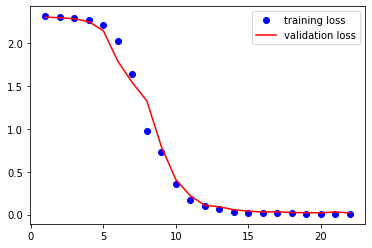

In [19]:
path = "C:\\Users\\yexue\\Gesture-Recognition-based-on-IMU"

plt.plot(range(1,len(train_losses)+1),train_losses,'bo',label = 'training loss')
plt.plot(range(1,len(val_losses)+1),val_losses,'r',label = 'validation loss')
plt.legend()
plt.savefig(os.path.join(path,"loss.jpg"))

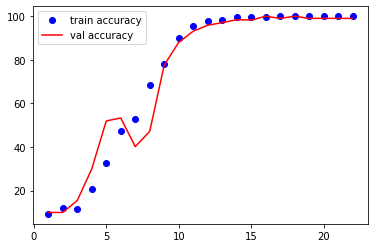

In [20]:
plt.plot(range(1,len(train_accuracy)+1),train_accuracy,'bo',label = 'train accuracy')
plt.plot(range(1,len(val_accuracy)+1),val_accuracy,'r',label = 'val accuracy')
plt.legend()
plt.savefig(os.path.join(path,"accuracy.jpg"))

In [166]:
# def train(epoch):
#     model.train()
#     for batch_idx, (data, target) in enumerate(train_data_loader):
#         optimizer.zero_grad()
#         output = model(data)
#         loss = F.nll_loss(output, target)
#         loss.backward()
#         optimizer.step()
#         if batch_idx % log_interval == 0:
#             print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                 epoch, batch_idx * len(data), len(train_data_loader.dataset),
#                 100. * batch_idx / len(train_data_loader), loss.item()))
#             train_losses.append(loss.item())
#             train_counter.append(
#                 (batch_idx*64) + ((epoch-1)*len(train_data_loader.dataset)))

In [167]:
# def test():
#     model.eval()
#     test_loss = 0
#     correct = 0
#     with torch.no_grad():
#         for data, target in valid_data_loader:
#             output = model(data)
#             test_loss += F.nll_loss(output, target, size_average=False).item()
#             pred = output.data.max(1, keepdim=True)[1]
#             correct += pred.eq(target.data.view_as(pred)).sum()
#     test_loss /= len(valid_data_loader.dataset)
#     test_losses.append(test_loss)
#     print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
#         test_loss, correct, len(valid_data_loader.dataset),
#         100. * correct / len(valid_data_loader.dataset)))

In [169]:
# n_epochs = 30
# batch_size_train = 64
# batch_size_test = 1000
# learning_rate = 0.01
# momentum = 0.5
# log_interval = 10

# train_losses = []
# train_counter = []
# test_losses = []
# test_counter = [i*len(train_data_loader.dataset) for i in range(n_epochs + 1)]

# test()
# for epoch in range(1, n_epochs + 1):
#     train(epoch)
#     test()


Test set: Avg. loss: 2.3004, Accuracy: 71/510 (14%)

Train Epoch: 1 [0/1040 (0%)]	Loss: 2.298346
Train Epoch: 1 [640/1040 (59%)]	Loss: 2.301919

Test set: Avg. loss: 2.2992, Accuracy: 75/510 (15%)

Train Epoch: 2 [0/1040 (0%)]	Loss: 2.294892
Train Epoch: 2 [640/1040 (59%)]	Loss: 2.301924

Test set: Avg. loss: 2.2985, Accuracy: 74/510 (15%)

Train Epoch: 3 [0/1040 (0%)]	Loss: 2.294682
Train Epoch: 3 [640/1040 (59%)]	Loss: 2.296587

Test set: Avg. loss: 2.2971, Accuracy: 88/510 (17%)

Train Epoch: 4 [0/1040 (0%)]	Loss: 2.292691
Train Epoch: 4 [640/1040 (59%)]	Loss: 2.301257

Test set: Avg. loss: 2.2957, Accuracy: 51/510 (10%)

Train Epoch: 5 [0/1040 (0%)]	Loss: 2.298717
Train Epoch: 5 [640/1040 (59%)]	Loss: 2.296419

Test set: Avg. loss: 2.2948, Accuracy: 51/510 (10%)

Train Epoch: 6 [0/1040 (0%)]	Loss: 2.296418
Train Epoch: 6 [640/1040 (59%)]	Loss: 2.291975

Test set: Avg. loss: 2.2927, Accuracy: 58/510 (11%)

Train Epoch: 7 [0/1040 (0%)]	Loss: 2.296333
Train Epoch: 7 [640/1040 (59%)]	

Text(0, 0.5, 'negative log likelihood loss')

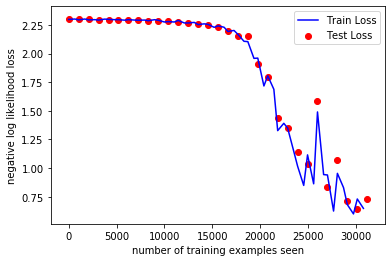

In [174]:
# fig = plt.figure()
# plt.plot(train_counter, train_losses, color='blue')
# plt.scatter(test_counter, test_losses, color='red')
# plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
# plt.xlabel('number of training examples seen')
# plt.ylabel('negative log likelihood loss')